# SimpleConv2d

2次元に対応した畳み込みニューラルネットワーク（CNN）のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。


プーリング層なども作成することで、CNNの基本形を完成させます。クラスの名前はScratch2dCNNClassifierとしてください。

## データセットの用意

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

### MNISTデータセット

In [3]:
# データの読み込み
(X_train,y_train),(X_test,y_test) = mnist.load_data()

# 正規化
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

# onehotベクトル化
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:,np.newaxis])
y_test_one_hot = enc.transform(y_test[:,np.newaxis])

# 訓練データと評価データに分ける
X_train_,X_val,y_train_,y_val = train_test_split(X_train,y_train_one_hot,test_size=0.2)

print(X_train.shape)
print(X_train_.shape)
print(X_val.shape)
print(y_train.shape)
print(y_train_.shape)
print(y_val.shape)

(60000, 28, 28)
(48000, 28, 28)
(12000, 28, 28)
(60000,)
(48000, 10)
(12000, 10)


### これまで使用してきたクラスを利用

In [4]:
class FC:
    """
    全結合層
    ----------
    n_nodes1 : 前のレイヤーのノード数
    n_nodes2 : 後続のレイヤーのノード数
    initializer : 初期化メソッドのインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer, activation):
        
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.initializer = initializer
        self.optimizer = optimizer
        self.activation = activation
        
        # W,Bを初期化
        self.W = self.initializer.W(self.n_nodes1,self.n_nodes2)
        self.B = self.initializer.B(self.n_nodes2)
        
    def forward(self, X):
        """
        順伝播
        ----------
        X : 次の形式のインプット (batch_size, n_nodes1)
        Returns
        ----------
        A : 次の形式のアウトプット (batch_size, n_nodes2)
        """
        self.X = X
        self.A = np.dot(self.X,self.W) + self.B
        
        return self.activation.forward(self.A)
    
    def backward(self, dZ):
        """
        逆伝播
        ----------
        dA : 次の形式の配列 (batch_size, n_nodes2)
        ----------
        dZ : 前の層から流れてきた値 (batch_size, n_nodes1)
        """
        dA = self.activation.backward(dZ)
        self.dB = np.mean(dA,axis=0)
        self.dW = np.dot(self.X.T,dA)/len(self.X)
        dZ = np.dot(dA,self.W.T)
        
        # UpdAte
        self = self.optimizer.updAte(self)
        
        return dZ

In [5]:
class SimpleInitializer:
    """
    ガウス分布による初期化
    ----------
    sigma : ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化       
        ----------
        n_nodes1 : 前のレイヤーのノード数
        n_nodes2 : 後続のレイヤーのノード数
        ----------
        W : 重み
        """
        return self.sigma * np.random.randn(n_nodes1, n_nodes2)
    
    def B(self, n_nodes2):
        """
        バイアスの初期化      
        ----------
        n_nodes2 : 後続のレイヤーのノード数
        ----------
        B : バイアス
        """
        return np.zeros(n_nodes2)

In [6]:
class HeInitializer():
    """
    Heによる重みの初期化
    """
    def __init__(self):
        pass
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        ----------
        n_nodes1 : 前のレイヤーのノード数
        n_nodes2 : 後続のレイヤーのノード数
        ----------
        W : 重み
        """
        return np.random.randn(n_nodes1, n_nodes2)*np.sqrt(2/n_nodes1)
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        ----------
        n_nodes2 : 後続のレイヤーのノード数
        ----------
        B : バイアス
        """
        return np.zeros(n_nodes2)

In [7]:
class SGD:
    """
    確率的勾配降下法
    ----------
    lr : 学習率
    """
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, layer):
        """
        レイヤーの重みとバイアスを更新する
        ----------
        layer : 更新前のレイヤーのインスタンス
        """
        layer.W -= self.lr*layer.dW
        layer.B -= self.lr*layer.dB
        
        return layer

In [27]:
class AdaGrad:
    """
    確率的勾配降下法
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        self.hW = 0
        self.hB = 0
        
    def updAte(self, layer):
        """
        レイヤーの重みとバイアスを更新する
        ----------
        layer : 更新前のレイヤーのインスタンス
        """
        self.hW += layer.dW*layer.dW
        self.hB = layer.dB*layer.dB
    
        layer.W -= self.lr*layer.dW/(np.sqrt(self.hW) +1e-7)
        layer.B -= self.lr*layer.dB/(np.sqrt(self.hB) +1e-7)
        
        return layer

In [9]:
class ReLU():
    """
    活性化関数：ReLU関数
    """
    def __init__(self):
        pass
        
    def forward(self,A):
        self.A = A
        return np.maximum(self.A,0)
    
    def backward(self,dZ):
        
        return np.where(self.A>0,dZ,0)

In [11]:
class Softmax():
    """
    活性化関数：ソフトマックス関数
    """
    def __init__(self):
        pass
        
    def forward(self,A):
        
        return np.exp(A-np.max(A))/np.sum(np.exp(A-np.max(A)),axis=1,keepdims=True)
    
    def backward(self,dZ):
        return dZ

In [12]:
# ミニバッチ処理クラス
class GetMiniBatch:
    """
    ミニバッチを取得するためのイテレータ

    Parameters
    ----------
    X : 訓練データ (n_samples, n_features)
    y : 正解値 (n_samples, 1)
    batch_size : バッチサイズ
    seed : 乱数のシード値
    """
    def __init__(self, X, y, batch_size = 20, seed=None):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
        
    def __len__(self):
        return self._stop
    
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1] 
    
    def __iter__(self):
        self._counter = 0
        return self
    
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

### 畳み込み層の重みとバイアスの初期化クラス

In [13]:
class SimpleInitializerConv2d:
    """重みとバイアスの初期化（畳込み用）"""
    def __init__(self, sigma=0.01):
        """コンストラクタ
        Parameters
        --------------
        sigma : ガウス分布の標準偏差
        """
        self.sigma = sigma
        
    def W(self, F, C, FH, FW):
        """重み初期化
        Parameters
        ----------
        F : フィルタ数
        C : チャンネル数
        FH : フィルターの高さ
        FW : フィルターの横幅
        """
        return self.sigma * np.random.randn(F,C,FH,FW)
    
    def B(self, F):
        """バイアス初期化
        Parameters
        ----------
        F : フィルタ数
        """
        return np.zeros(F)

## 【問題1】2次元畳み込み層の作成

1次元畳み込み層のクラスConv1dを発展させ、2次元畳み込み層のクラスConv2dを作成してください。


フォワードプロパゲーションの数式は以下のようになります。

$$
a_{i,j,m}=∑^{K-1}_{k=0}∑^{F_h-1}_{s=0}∑^{F_w-1}_{t=0}x_{(i+s),(j+t),k}w_{s,t,k,m}+b_m
$$

$a_{i,j,m}$ : 出力される配列のi行j列、mチャンネルの値


$i$ : 配列の行方向のインデックス


$j$ : 配列の列方向のインデックス


$m$ : 出力チャンネルのインデックス


$K$ : 入力チャンネル数


$F_{h}, F_{w}$ : 高さ方向（h）と幅方向（w）のフィルタのサイズ


$x_{(i+s),(j+t),k}$ : 入力の配列の(i+s)行(j+t)列、kチャンネルの値


$w_{s,t,k,m}$ : 重みの配列のs行t列目。kチャンネルの入力に対して、mチャンネルへ出力する重み


$b_m$ : mチャンネルへの出力のバイアス項

次に更新式です。1次元畳み込み層や全結合層と同じ形です。

$$
w′_{s,t,k,m}=w_{s,t,k,m}−α\frac{\partial L}{\partial w_{s,t,k,m}}
$$
$$
b′_m=b_m−α\frac{\partial L}{\partial b_{m}}
$$

$\alpha$ : 学習率


$\frac{\partial L}{\partial w_{s,t,k,m}}$ : $w_{s,t,k,m}$ に関する損失 $L$ の勾配


$\frac{\partial L}{\partial b_{m}}$ : $b_{m}$ に関する損失 $L$ の勾配

勾配 $\frac{\partial L}{\partial w_{s,t,k,m}}$ や $\frac{\partial L}{\partial b_{m}}$ を求めるためのバックプロパゲーションの数式が以下である。

$$
\frac{\partial L}{\partial w_{s,t,k,m}}=∑^{N_{out,h}-1}_{i=0} ∑^{N_{out,w}-1}_{j=0}\frac{\partial L}{\partial a_{i,j,m}}x_{(i+s)(j+t),k}
$$
$$
\frac{\partial L}{\partial b_{m}}=∑^{N_{out,h}−1}_{i=0}∑^{N_{out,w}−1}_{j=0}\frac{\partial L}{\partial a_{i,j,m}}
$$

$\frac{\partial L}{\partial a_i}$ : 勾配の配列のi行j列、mチャンネルの値


$N_{out,h},N_{out,w}$ : 高さ方向（h）と幅方向（w）の出力のサイズ

前の層に流す誤差の数式は以下です。

$$
\frac{\partial L}{\partial x_{i,j,k}}=∑^{M-1}_{m=0} ∑^{F_h-1}_{s=0} ∑^{F_w-1}_{t=0} \frac{\partial L}{\partial a_{(i-s),(j-t),m}}w_{s,t,k,m}
$$

$\frac{\partial L}{\partial x_{i,j,k}}$ : 前の層に流す誤差の配列のi列j行、kチャンネルの値


$M$ : 出力チャンネル数


ただし、 $i-s<0$ または $i-s>N_{out,h}-1$ または $j-t<0$ または $j-t>N_{out,w}-1$ のとき $\frac{\partial L}{\partial a_{(i-s),(j-t),m}} =0$ です。

In [14]:
class SimpleConv2d():
    """２次元畳み込みレイヤ"""
    def __init__(self,F,C,FH,FW,P,S,
                 initializer=None,
                 optimizer=None,
                 activation=None):
        """コンストラクタ
        ----------------
        F : フィルタ数
        C : チャンネル数
        FH : フィルターの高さ
        FW : フィルターの横幅
        P : パディング数
        S : ストライド数
        initializer : 初期化
        optimizer : 最適化手法
        activation : 活性化関数
        """
        
        self.P = P
        self.S = S
        self.initializer = initializer
        self.optimizer = optimizer
        self.activation = activation
        # 重みとバイアスの初期化
        self.W = self.initializer.W(F,C,FH,FW)
        self.B = self.initializer.B(F)
        
    def output_shape2d(self,H,W,PH,PW,FH,FW,SH,SW):
        """出力サイズ
        H : 入力配列の高さ
        W : 入力配列の横幅
        FH : フィルターの高さ
        FW : フィルターの横幅
        PH : パディング数（縦）
        PW : パディング数（横）
        SH : ストライド数（縦）
        SW : ストライド数（横）
        """
        # 高さ計算
        OH = (H + 2*PH - FH) / SH +1
        # 横幅の計算
        OW = (W + 2*PW - FW) / SW +1
        
        return int(OH),int(OW)
    
    def forward(self,X,debug=False):
        """順伝播
        X : 入力配列
        """
        # Xをメンバ変数化
        self.X = X
        # 入力配列と重みの大きさを取得
        N,C,H,W = self.X.shape
        F,C,FH,FW = self.W.shape
        # 出力サイズ計算
        OH,OW = self.output_shape2d(H,W,self.P,self.P,FH,FW,self.S,self.S)
        # 各種サイズをメンバ変数化
        self.params = N,C,H,W,F,FH,FW,OH,OW
        # 返り値んお初期化（上書き用）
        A = np.zeros([N,F,OH,OW])
        # 計算のためのパディング処理
        self.X_pad = np.pad(self.X,
                            ((0,0),
                             (0,0),
                             (self.P,self.P),
                             (self.P,self.P)))
        
        #　バッチ数でループ
        for n in range(N):
            # フィルター数でループ
            for ch in range(F):
                # 高さでループ（ストライドを考慮）
                for row in range(0,H,self.S):
                    # 横幅でループ（ストライドを考慮）
                    for col in range(0,W,self.S):
                        if self.P == 0 and (W-2<=col or H-2<=row):
                            continue
                        # 各要素計算
                        A[n,ch,row,col] = \
                        np.sum(self.X_pad[n,:,row:row+FH,col:col+FW]
                               *self.W[ch,:,:,:]) +self.B[ch]
        # 活性化関数に通して返す
        if debug == True:
            return A
        else:
            return self.activation.forward(A)
    
    def backward(self,dZ,debug=False):
        """逆伝播
        ------------
        dZ : 逆伝播してきた値
        """
        # 活性化関数の逆伝播処理
        if debug==True:
            dA = dZ
        else:
            dA = self.activation.backward(dZ)
        
        # 順伝播の際にメンバ変数化しておいた各種サイズを取得
        N,C,H,W,F,FH,FW,OH,OW = self.params
        
        # 返り値と重みとバイアスの初期化（これを上書きしていく）
        dZ = np.zeros(self.X_pad.shape) # X_padのサイズで初期化していることに注意
        self.dW = np.zeros(self.W.shape)
        self.dB = np.zeros(self.B.shape)
        
        # dZ(逆伝播)
        # バッチ数でループ
        for n in range(N):
            # フィルター数でループ
            for ch in range(F):
                # 高さでループ（ストライドを考慮）
                for row in range(0,H,self.S):
                    # 横幅でループ（ストライドを考慮）
                    for col in range(0,W,self.S):
                        if self.P == 0 and (W-2<=col or H-2<=row):
                            continue
                        # 各要素計算
                        dZ[n,:,row:row+FH,col:col+FW] += dA[n,ch,row,col]*self.W[ch,:,:,:]
                        
        # X_padのサイズになっているので、不要な部分を削除
        if self.P == 0:
            dZ = np.delete(dZ,[0,H-1],axis=2)
            dZ = np.delete(dZ,[0,W-1],axis=3)
        else:
            dl_rows = range(self.P),range(H+self.P,H+2*self.P,1)
            dl_cols = range(self.P),range(W+self.P,W+2*self.P,1)
            dZ = np.delete(dZ,dl_rows,axis=2)
            dZ = np.delete(dZ,dl_cols,axis=3)
            
        # dw(重み)
        # バッチ数でループ
        for n in range(N):
            # フィルター数でループ
            for ch in range(F):
                # 高さでループ
                for row in range(OH):
                    # 横幅でループ
                    for col in range(OW):
                        # 各要素計算
                        self.dW[ch,:,:,:] += dA[n,ch,row,col]*self.X_pad[n,
                                                                         :,
                                                                         row:row+FH,
                                                                         col:col+FW]
        # dB(バイアス)
        # フィルター数でループ
        for ch in range(F):
            self.dB[ch] = np.sum(dA[:,ch,:,:])
            
        # 重み更新
        self = self.optimizer.update(self)
        
        return dZ
                        

## 【問題2】小さな配列での2次元畳み込み層の実験

次に示す小さな配列でフォワードプロパゲーションとバックプロパゲーションが正しく行えているか確認してください。


入力 x、重み w を次のようにします。

In [15]:
# CNN2 のフォワードを流す時の入力データ
# (1,1,4,4)
x = np.array([[[[ 1,  2,  3,  4],
                [ 5,  6,  7,  8],
                [ 9, 10, 11, 12],
                [13, 14, 15, 16]]]])
# (2,3,3)
w = np.array([[[[ 0.,  0.,  0.],
               [ 0.,  1.,  0.],
               [ 0., -1.,  0.]]],
              [[[ 0.,  0.,  0.],
               [ 0., -1.,  1.],
               [ 0.,  0.,  0.]]]])
print(x.shape)
print(w.shape)

(1, 1, 4, 4)
(2, 1, 3, 3)


フォワードプロパゲーションをすると出力は次のようになります。

array([[[-4, -4],
        [-4, -4]],
       [[ 1,  1],
        [ 1,  1]]])

In [16]:
# インスタンス定義と重みの上書き
sc2d = SimpleConv2d(F=2,C=1,FH=3,FW=3,P=0,S=1,
                    initializer=SimpleInitializerConv2d(),
                    optimizer=SGD(),
                    activation=ReLU())
sc2d.W = w

In [17]:
# 順伝播
A = sc2d.forward(x,True)
print(A)

[[[[-4. -4.]
   [-4. -4.]]

  [[ 1.  1.]
   [ 1.  1.]]]]


次にバックプロパゲーションを考えます。誤差は次のようであったとします。

In [18]:
#(?,1,2,2,)
delta = np.array([[[[ -4,  -4],
                   [ 10,  11]],
                  [[  1,  -7],
                   [  1, -11]]]])
print(delta.shape)

(1, 2, 2, 2)


In [19]:
# 逆伝播
dZ = sc2d.backward(delta,True)
print(dZ)

[[[[-5.  4.]
   [13. 27.]]]]


バックプロパゲーションをすると次のような値になります。パディングがある場合は出力は次のようになります。

array([[-5,  4],
       [13, 27]])

## 【問題3】2次元畳み込み後の出力サイズ

畳み込みを行うと特徴マップのサイズが変化します。どのように変化するかは以下の数式から求められます。この計算を行う関数を作成してください。

$$
N_{h,out}=\frac{N_{h,in}+2P_h−F_h}{S_h}+1
$$
$$
N_{w,out}=\frac{N_{w,in}+2P_w−F_w}{S_w}+1
$$

$N_{out}$ : 出力のサイズ（特徴量の数）


$N_{in}$ : 入力のサイズ（特徴量の数）


$P$ : ある方向へのパディングの数


$F$ : フィルタのサイズ


$S$ : ストライドのサイズ


$h$ が高さ方向、 $w$ が幅方向である

In [20]:
def output_shape2d(self,H,W,PH,PW,FH,FW,SH,SW):
        """出力サイズ
        H : 入力配列の高さ
        W : 入力配列の横幅
        FH : フィルターの高さ
        FW : フィルターの横幅
        PH : パディング数（縦）
        PW : パディング数（横）
        SH : ストライド数（縦）
        SW : ストライド数（横）
        """
        # 高さ計算
        OH = (H + 2*PH - FH) / SH +1
        # 横幅の計算
        OW = (W + 2*PW - FW) / SW +1
        
        return int(OH),int(OW)

## 【問題4】最大プーリング層の作成

最大プーリング層のクラスMaxPool2Dを作成してください。プーリング層は数式で表さない方が分かりやすい部分もありますが、数式で表すとフォワードプロパゲーションは以下のようになります。

$$
a_{i,j,k}=max_{(p,q)∈P_{i,j}} x_{p,q,k}
$$

$P_{i,j}$ : i行j列への出力する場合の入力配列のインデックスの集合。 $S_{h}×S_{w}$ の範囲内の行（p）と列（q）


$S_{h}, S_{w}$ : 高さ方向（h）と幅方向（w）のストライドのサイズ


$(p,q)\in P_{i,j}$ : $P_{i,j}$ に含まれる行（p）と列（q）のインデックス


$a_{i,j,m}$ : 出力される配列のi行j列、kチャンネルの値


$x_{p,q,k}$ : 入力の配列のp行q列、kチャンネルの値

ある範囲の中でチャンネル方向の軸は残したまま最大値を計算することになります。


バックプロパゲーションのためには、フォワードプロパゲーションのときの最大値のインデックス $(p,q)$ を保持しておく必要があります。フォワード時に最大値を持っていた箇所にそのままの誤差を流し、そこ以外には0を入れるためです。

In [21]:
class MaxPool2D():
    """
    最大プーリング層
    """
    def __init__(self,P):
        """
        コンストラクタ
        ------------
        P : プーリング層
        """
        self.P = P
        # 順伝播の返り値
        self.PA = None
        # 最大値のインデックス記憶
        self.Pindex = None
        
    def forward(self,A):
        """
        順伝播
        --------
        A : 入力配列
        """
        # 入力配列のサイズ
        N,F,OH,OW = A.shape
        
        PS = self.P
        
        # 縦軸と横軸のスライド回数
        PH,PW = int(OH/PS),int(OW/PS)
        
        # 各種パラメータの保存
        self.params = N,F,OH,OW,PS,PH,PW
        
        # プーリング処理のための初期化
        self.PA = np.zeros([N,F,PH,PW])
        self.Pindex = np.zeros([N,F,PH,PW])
        
        # バッチ数でループ
        for n in range(N):
            # フィルター数でループ
            for ch in range(F):
                # 縦方向スライド回数
                for row in range(PH):
                    # 横方向スライド回数
                    for col in range(PW):
                        # 順伝播の値計算　
                        self.PA[n,ch,row,col] = \
                        np.max(A[n,
                                 ch,
                                 row*PS:row*PS+PS,
                                 col*PS:col*PS+PS])
                        # 最大値のインデックス
                        self.Pindex[n,ch,row,col] = \
                        np.argmax(A[n,
                                    ch,
                                    row*PS:row*PS+PS,
                                    col*PS:col*PS+PS])
        return self.PA
    
    def backward(self,dA):
        """
        逆伝播
        --------
        dA : 逆伝播してきた値
        """
        # 保存しておいた各種パラメータ取得
        N,F,OH,OW,PS,PH,PW = self.params
        # 逆伝播の値
        dP = np.zeros([N,F,OH,OW])
        # バッチ数でループ
        for n in range(N):
            # フィルター数でループ
            for ch in range(F):
                # 縦方向スライド回数
                for row in range(PH):
                    # 横方向スライド回数
                    for col in range(PW):
                        # 最大値を取得してきたインデックスの取得
                        idx = self.Pindex[n,ch,row,col]
                        # 逆伝播の一時保存変数
                        tmp = np.zeros((PS*PS))
                        for i in range(PS*PS):
                            # 該当インデックスはその値
                            if i == idx:
                                tmp[i] = dA[n,ch,row,col]
                            # それ以外は０
                            else:
                                tmp[i] = 0
                        # 返り値の該当場所に格納
                        dP[n,
                           ch,
                           row*PS:row*PS+PS,
                           col*PS:col*PS+PS] = tmp.reshape(PS,PS)
                        
        return dP

In [22]:
# テスト
# データ準備
X = np.random.randint(0,9,36).reshape(1,1,6,6)
print("--------X--------")
print(X)
print("shape")
print(X.shape)

# インスタンス生成、順伝播
Pooling = MaxPool2D(P=2)
A = Pooling.forward(X)
print("--------A--------")
print(A)
print("shape")
print(A.shape)

# 逆伝播してきた配列
dA = np.random.randint(0,9,9).reshape(A.shape)
print("--------dA--------")
print(dA)
print("shape")
print(dA.shape)

# 逆伝播
dZ = Pooling.backward(dA)
print("--------dZ--------")
print(dZ)
print("shape")
print(dZ.shape)

--------X--------
[[[[4 6 1 2 1 1]
   [3 5 2 4 6 1]
   [3 7 5 6 1 2]
   [3 8 3 5 7 6]
   [2 7 4 3 6 0]
   [2 6 5 0 0 5]]]]
shape
(1, 1, 6, 6)
--------A--------
[[[[6. 4. 6.]
   [8. 6. 7.]
   [7. 5. 6.]]]]
shape
(1, 1, 3, 3)
--------dA--------
[[[[4 8 4]
   [7 3 3]
   [1 4 6]]]]
shape
(1, 1, 3, 3)
--------dZ--------
[[[[0. 4. 0. 0. 0. 0.]
   [0. 0. 0. 8. 4. 0.]
   [0. 0. 0. 3. 0. 0.]
   [0. 7. 0. 0. 3. 0.]
   [0. 1. 0. 0. 6. 0.]
   [0. 0. 4. 0. 0. 0.]]]]
shape
(1, 1, 6, 6)


## 【問題5】（アドバンス課題）平均プーリングの作成

## 【問題6】平滑化

平滑化するためのFlattenクラスを作成してください。


フォワードのときはチャンネル、高さ、幅の3次元を1次元にreshapeします。その値は記録しておき、バックワードのときに再びreshapeによって形を戻します。


この平滑化のクラスを挟むことで出力前の全結合層に適した配列を作ることができます。

** 分類にしろ回帰にしろ、2次元のままじゃ扱えない **

In [23]:
class Flatten:
    """
    平滑化
    """
    def __init__(self):
        """コンストラクタ"""
        
    def forward(self,X):
        """
        順伝播
        --------
        X : 入力配列
        """
        self.shape = X.shape
        return X.reshape(len(X),-1)
    
    def backward(self,X):
        """
        逆伝播
        --------
        X : 逆伝播してきた値
        """
        return X.reshape(self.shape)

In [24]:
# テスト
# データ生成
test = np.zeros([20,2,5,5])

# インスタンス化
flt = Flatten()

# 順伝播
flat_forward = flt.forward(test)

# 逆伝播
flat_back = flt.backward(flat_forward)

print("flat_forward")
print(flat_forward.shape)
print("back")
print(flat_back.shape)

flat_forward
(20, 50)
back
(20, 2, 5, 5)


## 【問題7】学習と推定

In [25]:
# Scratch CNN
class Scratch2dCNNClassifier():
    """
    CNNスクラッチ
    """
    def __init__(self,NN,CNN,n_epoch=5,n_batch=1,verbose = False):
        """
        コンストラクタ
        ------------
        NN : 辞書型でレイヤーのインスタンスを格納
        CNN : 辞書型でレイヤーのインスタンスを格納
        n_epoch : 学習回数
        n_batch : バッチ数
        verbose : ログ出力の有無
        """
        self.NN = NN
        self.CNN = CNN
        self.n_epoch = n_epoch
        self.n_batch = n_batch
        self.verbose = verbose
        
        # ログ記録
        self.log_loss = np.zeros(self.n_epoch)
        self.log_acc = np.zeros(self.n_epoch)
        
    def loss_function(self,y,yt):
        """
        クロスエントロピー誤差
        ------------
        y : 予測値
        yt : 正解データ
        """
        delta = 1e-7
        return -np.mean(yt*np.log(y+delta))
    
    def accuracy(self,Z,Y):
        """
        クロスエントロピー誤差
        ------------
        Z : 予測値
        Y : 正解データ
        """
        return accuracy_score(Y,Z)
    
    def fit(self,X,y,X_val=False,y_val=False):
        """
        学習
        ------------
        X : 訓練データの説明変数
        y : 訓練データの目的変数
        X_VaL : 評価データの説明変数
        y_val : 評価データの目的変数
        """
        # 学習回数分ループ
        for epoch in range(self.n_epoch):
            # ミニバッチイテレータ生成
            get_mini_batch = GetMiniBatch(X,y,batch_size=self.n_batch)
            # バッチの合計損失格納
            self.loss = 0
            # ミニバッチイテレータでループ
            for mini_X_train,mini_y_train in get_mini_batch:
                """順伝播"""
                # データ準備
                forward_data = mini_X_train[:,np.newaxis,:,:]
                # 畳み込み
                for layer in range(len(self.CNN)):
                    forward_data = self.CNN[layer].forward(forward_data)
                # 平滑化
                flt = Flatten()
                forward_data = flt.forward(forward_data)
                # 通常のNN
                for layer in range(len(self.NN)):
                    forward_data = self.NN[layer].forward(forward_data)
                """逆伝播"""
                # データ準備
                Z = forward_data
                backward_data = (Z - mini_y_train)/self.n_batch
                # 通常のNN
                for layer in range(len(self.NN)-1,-1,-1):
                    backward_data = self.NN[layer].backward(backward_data)
                # 損失計算
                self.loss += self.loss_function(Z,mini_y_train)
                if self.verbose:
                    print('batch loss %f'%self.loss_function(Z,mini_y_train))
                    
            if self.verbose:
                print(self.loss/len(get_mini_batch),
                      self.accuracy(self.predict(X),
                                    np.argmax(y,axis=1)))
            # 損失記録用
            self.log_loss[epoch] = self.loss/len(get_mini_batch)
            self.log_acc[epoch] = self.accuracy(self.predict(X),np.argmax(y,axis=1))
            
    def predict(self,X):
        """
        予測
        --------
        X : 説明変数
        """
        # データ準備
        pred_data = X[:,np.newaxis,:,:]
        
        # 畳み込み
        for layer in range(len(self.CNN)):
            pred_data = self.CNN[layer].forward(pred_data)
        # 平滑化
        pred_data = flt.forward(pred_data)
        # 通常のNN
        for layer in range(len(self.NN)):
            pred_data = self.NN[layer].forward(pred_data)
        # 最も大きいインデックスを採用
        return np.argmax(pred_data,axis=1)

In [28]:
# レイヤー定義
NN = {
    0:FC(1960,200,HeInitializer(),AdaGrad(0.01),ReLU()),
    1:FC(200,200,HeInitializer(),AdaGrad(0.01),ReLU()),
    2:FC(200,10,SimpleInitializer(0.01),AdaGrad(0.01),Softmax()),
}

CNN = {
    0:SimpleConv2d(
        F=10,C=1,FH=3,FW=3,P=1,S=1,
        initializer=SimpleInitializerConv2d(),
        activation=ReLU()),
    1:MaxPool2D(2),
}

In [29]:
# CNNクラスのインスタンス化
cnn1 = Scratch2dCNNClassifier(NN=NN,CNN=CNN,n_epoch=1,n_batch=20,verbose=True)

In [30]:
# 学習
cnn1.fit(X_train[0:1000],y_train_one_hot[0:1000])

batch loss 0.230321
batch loss 0.230641
batch loss 0.233910
batch loss 0.229153
batch loss 0.226589
batch loss 0.228736
batch loss 0.229100
batch loss 0.219070
batch loss 0.214422
batch loss 0.223519
batch loss 0.221627
batch loss 0.220700
batch loss 0.205785
batch loss 0.207937
batch loss 0.206673
batch loss 0.196683
batch loss 0.208845
batch loss 0.199921
batch loss 0.182331
batch loss 0.196034
batch loss 0.168002
batch loss 0.185678
batch loss 0.175172
batch loss 0.166525
batch loss 0.158924
batch loss 0.144084
batch loss 0.145694
batch loss 0.152679
batch loss 0.190145
batch loss 0.153257
batch loss 0.160359
batch loss 0.136425
batch loss 0.175355
batch loss 0.117193
batch loss 0.130209
batch loss 0.117725
batch loss 0.129837
batch loss 0.137029
batch loss 0.104608
batch loss 0.152393
batch loss 0.150083
batch loss 0.153836
batch loss 0.151528
batch loss 0.141977
batch loss 0.122138
batch loss 0.134514
batch loss 0.110440
batch loss 0.102441
batch loss 0.098412
batch loss 0.110060


In [31]:
# 予測
y_pred = cnn1.predict(X_val[0:100])

# ACC算出
accuracy = accuracy_score(np.argmax(y_val[0:100],axis=1),y_pred)
print("accuracy")
print(accuracy)

accuracy
0.65


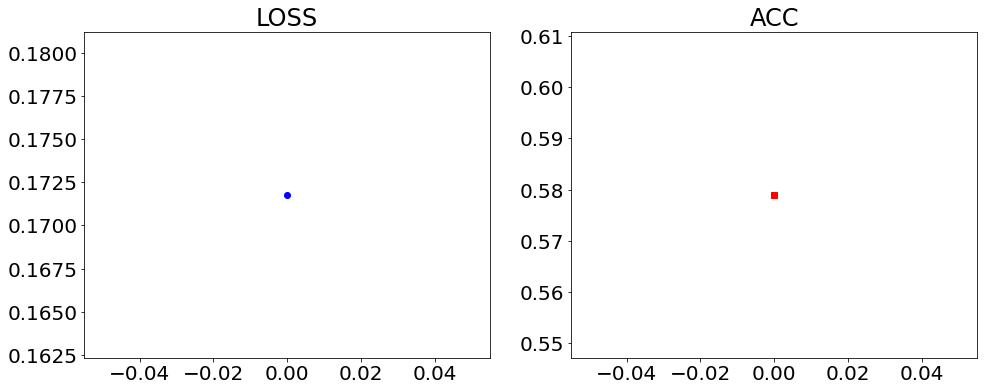

In [32]:
# 可視化
plt.rcParams["font.size"] = 20
fig=plt.subplots(figsize=(16,6))
plt.subplot(1,2,1)
plt.title('LOSS')
plt.plot(cnn1.log_loss,'bo--')

plt.subplot(1,2,2)
plt.title('ACC')
plt.plot(cnn1.log_acc,'rs--');

## 【問題8】（アドバンス課題）LeNet

## 【問題9】（アドバンス課題）有名な画像認識モデルの調査

## 【問題10】出力サイズとパラメータ数の計算

1.

* 入力サイズ : 144×144, 3チャンネル
* フィルタサイズ : 3×3, 6チャンネル
* ストライド : 1
* パディング : なし

→ 出力サイズ：6×142×142

→ パラメータ数（重み）（F×C×FH×FW）：162

→ パラメータ数（バイアス）（F）：6

2.

* 入力サイズ : 60×60, 24チャンネル
* フィルタサイズ : 3×3, 48チャンネル
* ストライド　: 1
* パディング : なし

→ 出力サイズ：48×58×58

→ パラメータ数（重み）（F×C×FH×FW）：10368

→ パラメータ数（バイアス）（F）：48

3.

* 入力サイズ : 20×20, 10チャンネル
* フィルタサイズ: 3×3, 20チャンネル
* ストライド : 2
* パディング : なし

→ 出力サイズ：20x9x9

→ パラメータ数（重み）（F×C×FH×FW）：1800

→ パラメータ数（バイアス）（F）：20

## 【問題11】（アドバンス課題）フィルタサイズに関する調査